In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import os

In [22]:
os.chdir('C:\\Users\\johnb\\Documents\\algotrading\\model')
df = pd.read_csv("5min.csv")

In [23]:
titles = ['open',
            'high',
            'low',
            'close',
            'volume',
            'quote asset volume',
            'trades',
            'tbbav',
            'tbqav']

feature_keys = ['open',
                'high',
                'low',
                'close',
                'volume',
                'qav',
                'trades',
                'tbbav',
                'tbqav']

colors = ["blue",
            "orange",
            "green",
            "red",
            "purple",
            "blue",
            "orange",
            "green",
            "red"]

date_time_key = "opentime"

In [24]:
for key in feature_keys:
    print(type(df[key][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [25]:
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=5, ncols=2, figsize=(15, 10), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()
    plt.show()

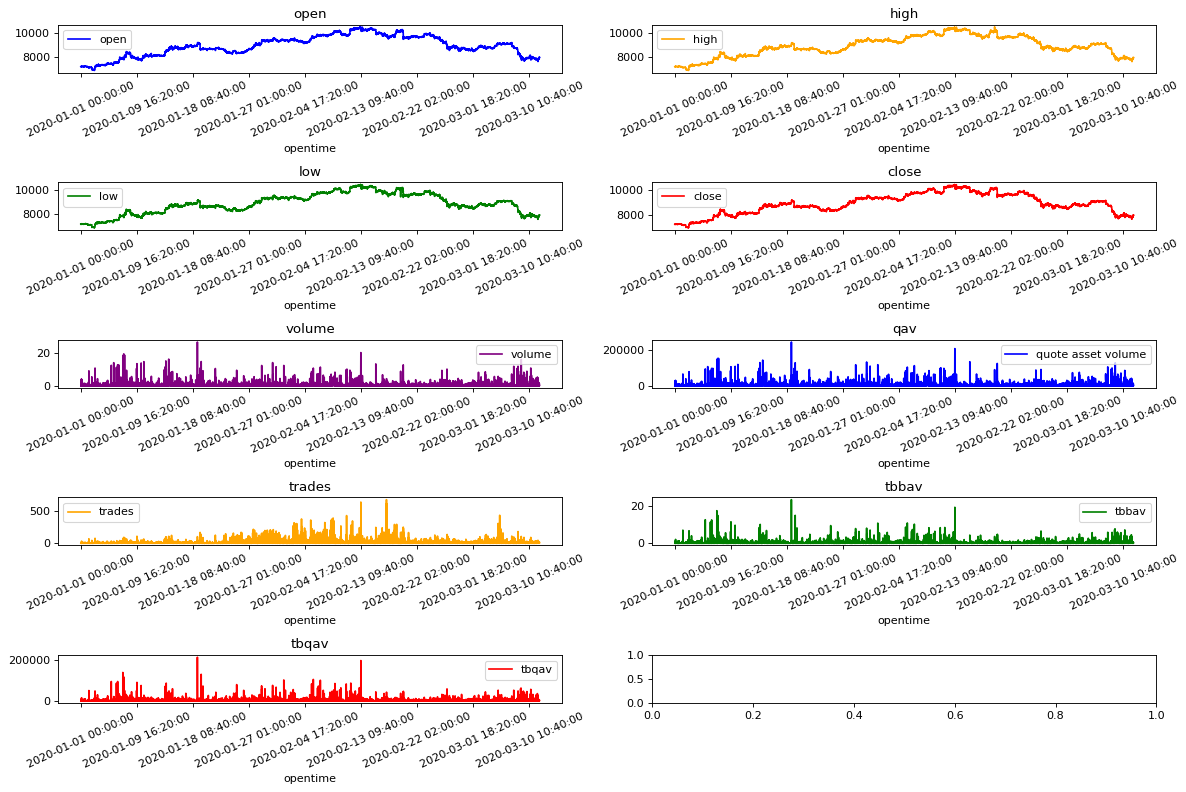

In [26]:
show_raw_visualization(df)

In [27]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

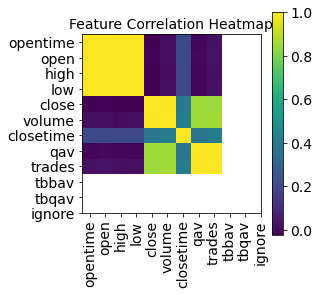

In [28]:
show_heatmap(df)

In [29]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [30]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 12 # 12 for 5 minutes

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10

In [31]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0,1,2,3,4,5,6,7,8]]),
)
selected_features = [feature_keys[i] for i in [0,1,2,3,4,5,6,7,8]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

The selected parameters are: open, high, low, close, volume, quote asset volume, trades, tbbav, tbqav


In [32]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(len(selected_features))]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)
print(len(x_train), len(y_train))

14621 14621


In [33]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [34]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(len(selected_features))]].values
y_val = features.iloc[label_start:][[1]]

In [35]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [36]:
for batch in dataset_train.take(1):
    inputs, targets = batch

In [37]:
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Input shape: (256, 60, 9)
Target shape: (256, 1)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 9)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 5,409
Trainable params: 5,409
Non-trainable params: 0
_________________________________________________________________


In [38]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [39]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
55/55 [==============================] - 4s 44ms/step - loss: 0.8205 - val_loss: 0.0913

Epoch 00001: val_loss improved from inf to 0.09133, saving model to model_checkpoint.h5
Epoch 2/10
55/55 [==============================] - 2s 36ms/step - loss: 0.0828 - val_loss: 0.0653

Epoch 00002: val_loss improved from 0.09133 to 0.06527, saving model to model_checkpoint.h5
Epoch 3/10
55/55 [==============================] - 2s 36ms/step - loss: 0.0707 - val_loss: 0.0592

Epoch 00003: val_loss improved from 0.06527 to 0.05924, saving model to model_checkpoint.h5
Epoch 4/10
55/55 [==============================] - 2s 36ms/step - loss: 0.0363 - val_loss: 0.0552

Epoch 00004: val_loss improved from 0.05924 to 0.05516, saving model to model_checkpoint.h5
Epoch 5/10
55/55 [==============================] - 2s 35ms/step - loss: 0.0342 - val_loss: 0.0495

Epoch 00005: val_loss improved from 0.05516 to 0.04954, saving model to model_checkpoint.h5
Epoch 6/10
55/55 [==========================

In [40]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

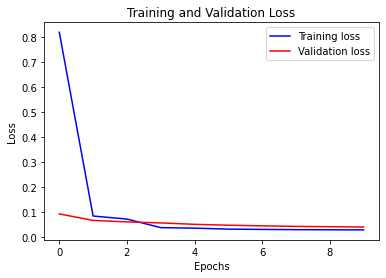

In [41]:
visualize_loss(history, "Training and Validation Loss")

In [42]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

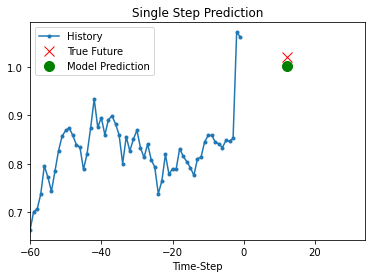

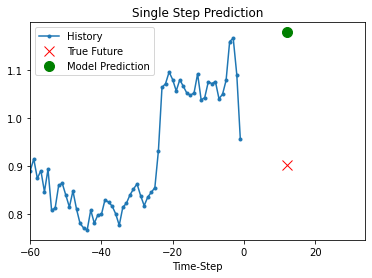

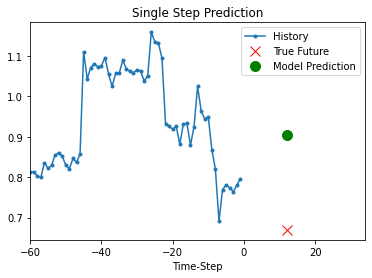

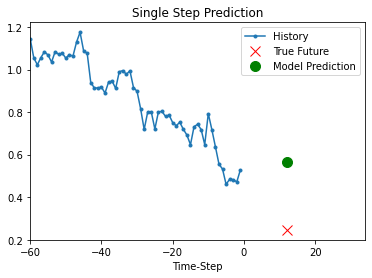

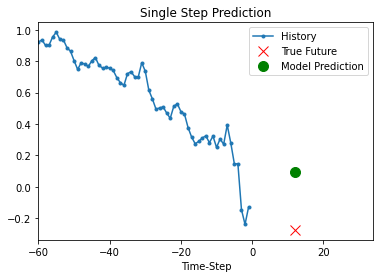

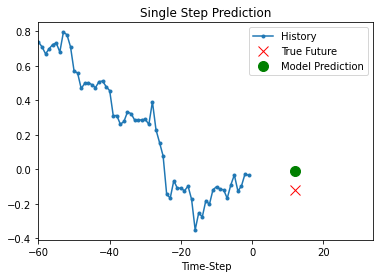

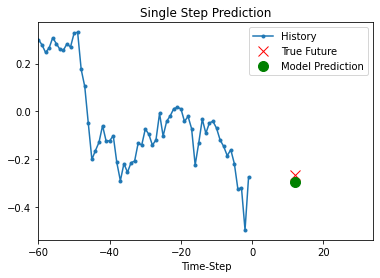

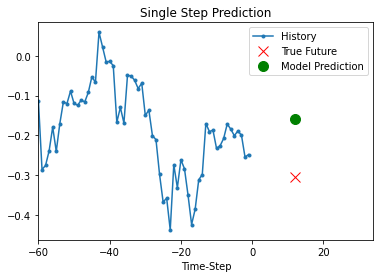

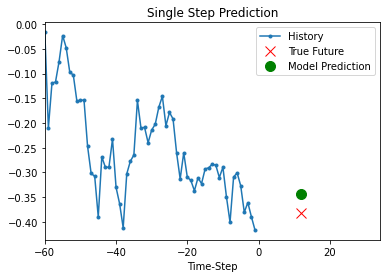

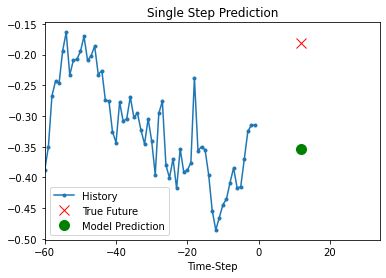

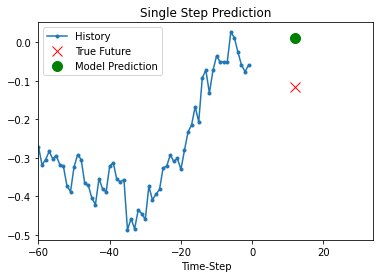

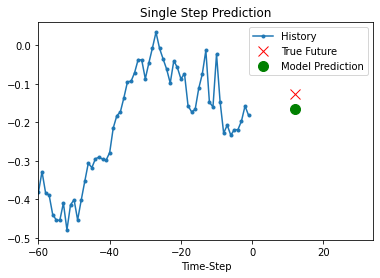

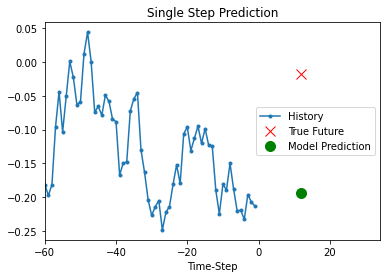

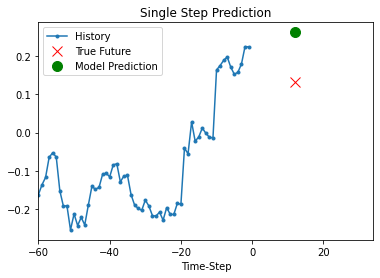

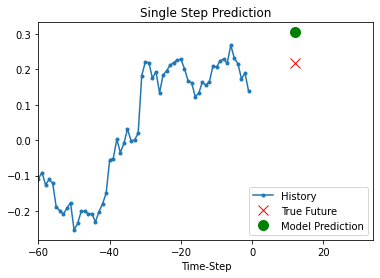

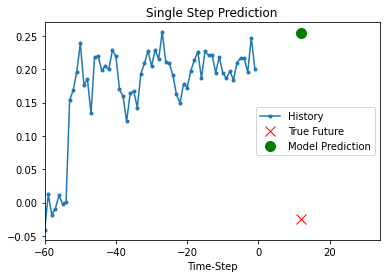

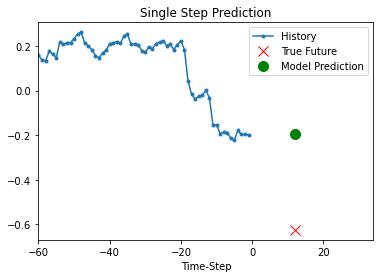

In [43]:
for x, y in dataset_val:
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )